## README

This notebook cumulatively plots the Membership Inference Attack Results obtained from the following notebooks:
  - ```Membership_Inference_bench.ipynb```
  - ```Membership_Inference_gs20p.ipynb```

If you had problems (dependency issues) running these notebooks, or it simply took to long, you can use our previously obtained results under the following folder hierarchy to reproduce these results:

  - Main
   - results
     - Membership_Inf
       - privacy_evaluator_variant.pickle
       - client_accuracies_variant.pickle
       - global_accuracies_variant.pickle


### Caution
Please make sure you run the ```pip install`` commands below. To be more specific you, need:
  - ```tensorflow==2.15.0```
  - ```tensorflow-privacy==0.9.0```


### Result Explanation

Instead of simplified heatmaps like in the manuscript, you will see the line plots illustrating the Attacker F1 Score (Attacker Advantage) and Privacy Vulnerability (TPR-FPR) scores per epoch per model. After applying GS to the data as transforamtions, you will observe that the corresponding model trained with this data will have a significantly less vulnerability scores against Membership Inference Attack.

In [ ]:
## Please run these pip installs if you ahve the different versions of these libraries!
# !pip install tensorflow==2.15.0
# !pip install tensorflow-privacy==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully unin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.5 MB/s eta 0:00:00
  Attempting uninstall: dm-tree
    Found existing installation: dm-tree 0.1.9
    Uninstalling dm-tree-0.1.9:
      Successfully uninstalled dm-tree-0.1.9
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.25.0
    Uninstalling tensorflow-probability-0.25.0:
      Successfully uninstalled tensorflow-probability-0.25.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and Functions

In [ ]:
import os
import sys
import numpy as np
import pickle
import gc
import logging
from typing import Tuple, List, Dict, Union, Optional
from dataclasses import dataclass
from collections import defaultdict

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from scipy import special
from sklearn.model_selection import KFold
import seaborn as sns

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Suppress warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
np.seterr(divide='ignore', invalid='ignore')

# Local TF-privacy path setup
LOCAL_TFPATH = '/content/drive/MyDrive/Spring 25/github_brainfl/Membership_inference/tf_privacy_module'
if LOCAL_TFPATH not in sys.path:
    sys.path.insert(0, LOCAL_TFPATH)


from tensorflow.keras import backend as K

# # TF Privacy imports
import tensorflow_privacy
# from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import (
#     membership_inference_attack as mia,
#     privacy_report
# )
# from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import (
#     AttackInputData,
#     AttackResultsCollection,
#     PrivacyMetric,
#     AttackType,
#     PrivacyReportMetadata,
#     SlicingSpec
# )


# Create a mock class for unpickling
class PicklableFederatedPrivacyEvaluator:
    """Mock class to enable loading the privacy evaluator pickle file."""
    pass

# Register the class in the main module
sys.modules["__main__"].PicklableFederatedPrivacyEvaluator = PicklableFederatedPrivacyEvaluator

def load_pickle_safely(path):
    """Load a pickle file safely."""
    if not os.path.exists(path):
        logger.error(f"File not found: {path}")
        return None

    try:
        with open(path, 'rb') as f:
            data = pickle.load(f)
            logger.info(f"Successfully loaded {path}")
            return data
    except Exception as e:
        logger.error(f"Error loading {path}: {e}")
        return None

def compute_metrics(conf_dict):
    """Compute metrics from a confusion matrix dictionary."""
    if not conf_dict:
        return None
    try:
        tp = conf_dict["tp"]
        fp = conf_dict["fp"]
        tn = conf_dict["tn"]
        fn = conf_dict["fn"]
    except Exception as e:
        logger.error(f"Error extracting metrics from conf_dict: {e}")
        return None

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (tp + tn) if (tp + tn) > 0 else 0 # Corrected bug here: changed tp+fn to tp+tn
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    vulnerability = tpr - fpr
    f1_score = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0

    return {
        "tpr": tpr,
        "fpr": fpr,
        "precision": precision,
        "vulnerability": vulnerability,
        "f1_score": f1_score
    }

In [ ]:
def plot_vulnerability(privacy_evaluator, model_type="global", client_id=None, title_prefix=None):
    """
    Plot privacy vulnerability per round.

    Args:
        privacy_evaluator: The loaded privacy evaluator object
        model_type: Either "global" or "client"
        client_id: Client ID (only used if model_type is "client")
        title_prefix: Optional prefix for the plot title
    """
    title = f"{title_prefix} " if title_prefix else ""
    version = "original"  # Hard-coded to use the original version

    try:
        if model_type == "global":
            # Extract global confusion matrices
            confusion_matrices = privacy_evaluator.confusion_matrices['global'].get(version, [])
            confusion_matrices = [cm for cm in confusion_matrices if cm]

            if not confusion_matrices:
                logger.warning("No valid global confusion matrices found")
                return

            # Compute metrics
            metrics_list = [compute_metrics(cm) for cm in confusion_matrices]
            metrics_list = [m for m in metrics_list if m is not None]

            plot_title = f"{title}Global Model Privacy Vulnerability Per Round"
        else:
            # Extract client confusion matrices
            client_confusions = privacy_evaluator.confusion_matrices['client'].get(version, [])

            if not client_confusions:
                logger.warning("No valid client confusion matrices found")
                return

            # Extract metrics for this client
            metrics_list = []
            for round_data in client_confusions:
                if isinstance(round_data, list) and len(round_data) > client_id and round_data[client_id]:
                    met = compute_metrics(round_data[client_id])
                    if met is not None:
                        metrics_list.append(met)

            plot_title = f"{title}Client {client_id} Privacy Vulnerability Per Round"

        if not metrics_list:
            logger.warning(f"No valid metrics found for {'global model' if model_type == 'global' else f'client {client_id}'}")
            return

        # Create the vulnerability plot
        plt.figure(figsize=(14, 8), dpi=100)

        # Plot vulnerability
        vulnerabilities = [m["vulnerability"] for m in metrics_list]
        rounds = range(1, len(vulnerabilities) + 1)

        plt.plot(rounds, vulnerabilities, '-o', linewidth=2.5, markersize=10, color='blue', label='Vulnerability')

        # Add enhanced grid with better visibility
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title(plot_title, fontsize=20, pad=15)
        plt.xlabel("Round", fontsize=18, labelpad=10)
        plt.ylabel("Vulnerability (TPR-FPR)", fontsize=18, labelpad=10)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=16, framealpha=0.7)

        # Add more padding around the plot
        plt.tight_layout(pad=3.0)
        plt.show()

    except Exception as e:
        logger.error(f"Error plotting vulnerability: {e}")


def plot_f1_score_and_accuracy_same_scale(privacy_evaluator, global_accuracies, client_accuracies,
                                          model_type="global", client_id=None, title_prefix=None):
    """
    Plot attack F1 score and model accuracy on the same scale.

    Args:
        privacy_evaluator: The loaded privacy evaluator object
        global_accuracies: Global model accuracies
        client_accuracies: Client model accuracies
        model_type: Either "global" or "client"
        client_id: Client ID (only used if model_type is "client")
        title_prefix: Optional prefix for the plot title
    """
    title = f"{title_prefix} " if title_prefix else ""
    version = "original"  # Hard-coded to use the original version

    try:
        if model_type == "global":
            # Extract global confusion matrices
            confusion_matrices = privacy_evaluator.confusion_matrices['global'].get(version, [])
            confusion_matrices = [cm for cm in confusion_matrices if cm]

            if not confusion_matrices:
                logger.warning("No valid global confusion matrices found")
                return

            # Compute metrics
            metrics_list = [compute_metrics(cm) for cm in confusion_matrices]
            metrics_list = [m for m in metrics_list if m is not None]

            # Get accuracy data
            accuracies = global_accuracies[:len(metrics_list)] if global_accuracies else None

            plot_title = f"{title}Global Model Attack F1 Score and Model Accuracy"
        else:
            # Extract client confusion matrices
            client_confusions = privacy_evaluator.confusion_matrices['client'].get(version, [])

            if not client_confusions:
                logger.warning("No valid client confusion matrices found")
                return

            # Extract metrics for this client
            metrics_list = []
            for round_data in client_confusions:
                if isinstance(round_data, list) and len(round_data) > client_id and round_data[client_id]:
                    met = compute_metrics(round_data[client_id])
                    if met is not None:
                        metrics_list.append(met)

            # Get client accuracy data
            if client_accuracies and len(client_accuracies) > client_id:
                # Use validation accuracy (index 1)
                accuracies = [acc[1] for acc in client_accuracies[client_id]][:len(metrics_list)]
            else:
                accuracies = None

            plot_title = f"{title}Client {client_id} Attack F1 Score and Model Accuracy"

        if not metrics_list:
            logger.warning(f"No valid metrics found for {'global model' if model_type == 'global' else f'client {client_id}'}")
            return

        # Create the F1 score and accuracy plot on same scale
        plt.figure(figsize=(14, 8), dpi=100)

        # Plot F1 score and accuracy on the same axis
        f1_scores = [m["f1_score"] for m in metrics_list]
        rounds = range(1, len(f1_scores) + 1)

        plt.plot(rounds, f1_scores, '-o', linewidth=2.5, markersize=10,
                color='blue', label="Attack F1 Score")

        # Plot accuracy if available
        if accuracies:
            # Make sure accuracies matches the number of rounds
            acc_rounds = range(1, len(accuracies) + 1)
            plt.plot(acc_rounds, accuracies, '-s', linewidth=2.5, markersize=10,
                    color='green', label="Model Accuracy")

        # Add threshold line at 0.5
        plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5,
                    label="Decision Threshold (0.5)")

        # Enhanced grid with better visibility
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title(plot_title, fontsize=20, pad=15)
        plt.xlabel("Round", fontsize=18, labelpad=10)
        plt.ylabel("Score", fontsize=18, labelpad=10)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=16, loc="upper right", framealpha=0.7)

        # Set y-axis limits to ensure the threshold is visible
        plt.ylim([0, 1.05])

        # Add more padding around the plot
        plt.tight_layout(pad=3.0)
        plt.show()

    except Exception as e:
        logger.error(f"Error plotting F1 score and accuracy: {e}")




def plot_vulnerability_and_f1_with_accuracy(privacy_evaluator, global_accuracies, client_accuracies,
                                           model_type="global", client_id=None, title_prefix=None):
    """
    Plot vulnerability (with polynomial fit) and F1 score with accuracy in two subplots (1,2 layout).

    Args:
        privacy_evaluator: The loaded privacy evaluator object
        global_accuracies: Global model accuracies
        client_accuracies: Client model accuracies
        model_type: Either "global" or "client"
        client_id: Client ID (only used if model_type is "client")
        title_prefix: Optional prefix for the plot title
    """
    title = f"{title_prefix} " if title_prefix else ""
    version = "original"  # Hard-coded to use the original version

    try:
        if model_type == "global":
            confusion_matrices = privacy_evaluator.confusion_matrices['global'].get(version, [])
            confusion_matrices = [cm for cm in confusion_matrices if cm]

            if not confusion_matrices:
                logger.warning("No valid global confusion matrices found")
                return

            metrics_list = [compute_metrics(cm) for cm in confusion_matrices]
            metrics_list = [m for m in metrics_list if m is not None]

            accuracies = global_accuracies[:len(metrics_list)] if global_accuracies else None
            main_title = f"{title}Global Model Privacy Metrics"
        else:
            client_confusions = privacy_evaluator.confusion_matrices['client'].get(version, [])

            if not client_confusions:
                logger.warning("No valid client confusion matrices found")
                return

            metrics_list = []
            for round_data in client_confusions:
                if isinstance(round_data, list) and len(round_data) > client_id and round_data[client_id]:
                    met = compute_metrics(round_data[client_id])
                    if met is not None:
                        metrics_list.append(met)

            if client_accuracies and len(client_accuracies) > client_id:
                accuracies = [acc[1] for acc in client_accuracies[client_id]][:len(metrics_list)]
            else:
                accuracies = None

            main_title = f"{title}Client {client_id} Privacy Metrics"

        if not metrics_list:
            logger.warning(f"No valid metrics found for {'global model' if model_type == 'global' else f'client {client_id}'}")
            return

        vulnerabilities = [m["vulnerability"] for m in metrics_list]
        f1_scores = [m["f1_score"] for m in metrics_list]
        rounds = np.arange(1, len(metrics_list) + 1)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=100)

        # Plot vulnerability with polynomial fit
        ax1.plot(rounds, vulnerabilities, '-o', linewidth=2.5, markersize=10, color='blue', label='Vulnerability')

        fit_coefficients = np.polyfit(rounds, vulnerabilities, deg=1)
        fitted_curve = np.poly1d(fit_coefficients)
        x_smooth = np.linspace(rounds.min(), rounds.max(), 300)
        y_smooth = fitted_curve(x_smooth)
        ax1.plot(x_smooth, y_smooth, '--', linewidth=2.5, color='red', label='Trend Line')

        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.set_title("Privacy Vulnerability Per Round", fontsize=18, pad=10)
        ax1.set_xlabel("Round", fontsize=16, labelpad=8)
        ax1.set_ylabel("Vulnerability (TPR-FPR)", fontsize=16, labelpad=8)
        ax1.tick_params(axis='both', labelsize=14)
        ax1.legend(fontsize=14, framealpha=0.7)

        # Plot F1 score and accuracy
        ax2.plot(rounds, f1_scores, '-o', linewidth=2.5, markersize=10, color='blue', label='Attack F1 Score')
        ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='Decision Threshold (0.5)')

        if accuracies:
            acc_rounds = np.arange(1, len(accuracies) + 1)
            ax2.plot(acc_rounds, accuracies, '-s', linewidth=2.5, markersize=10, color='green', label='Model Accuracy')
            ax2.set_ylim([0, 1.05])

        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.set_title("Attack F1 Score and Model Accuracy", fontsize=18, pad=10)
        ax2.set_xlabel("Round", fontsize=16, labelpad=8)
        ax2.set_ylabel("Score", fontsize=16, labelpad=8)
        ax2.tick_params(axis='both', labelsize=14)
        ax2.legend(fontsize=14, framealpha=0.7)

        fig.suptitle(main_title, fontsize=22, y=0.98)

        plt.tight_layout(pad=3.0)
        plt.subplots_adjust(top=0.90)
        plt.show()

    except Exception as e:
        logger.error(f"Error plotting combined visualization: {e}")

# Main Execution Block

### Bench Model/Data

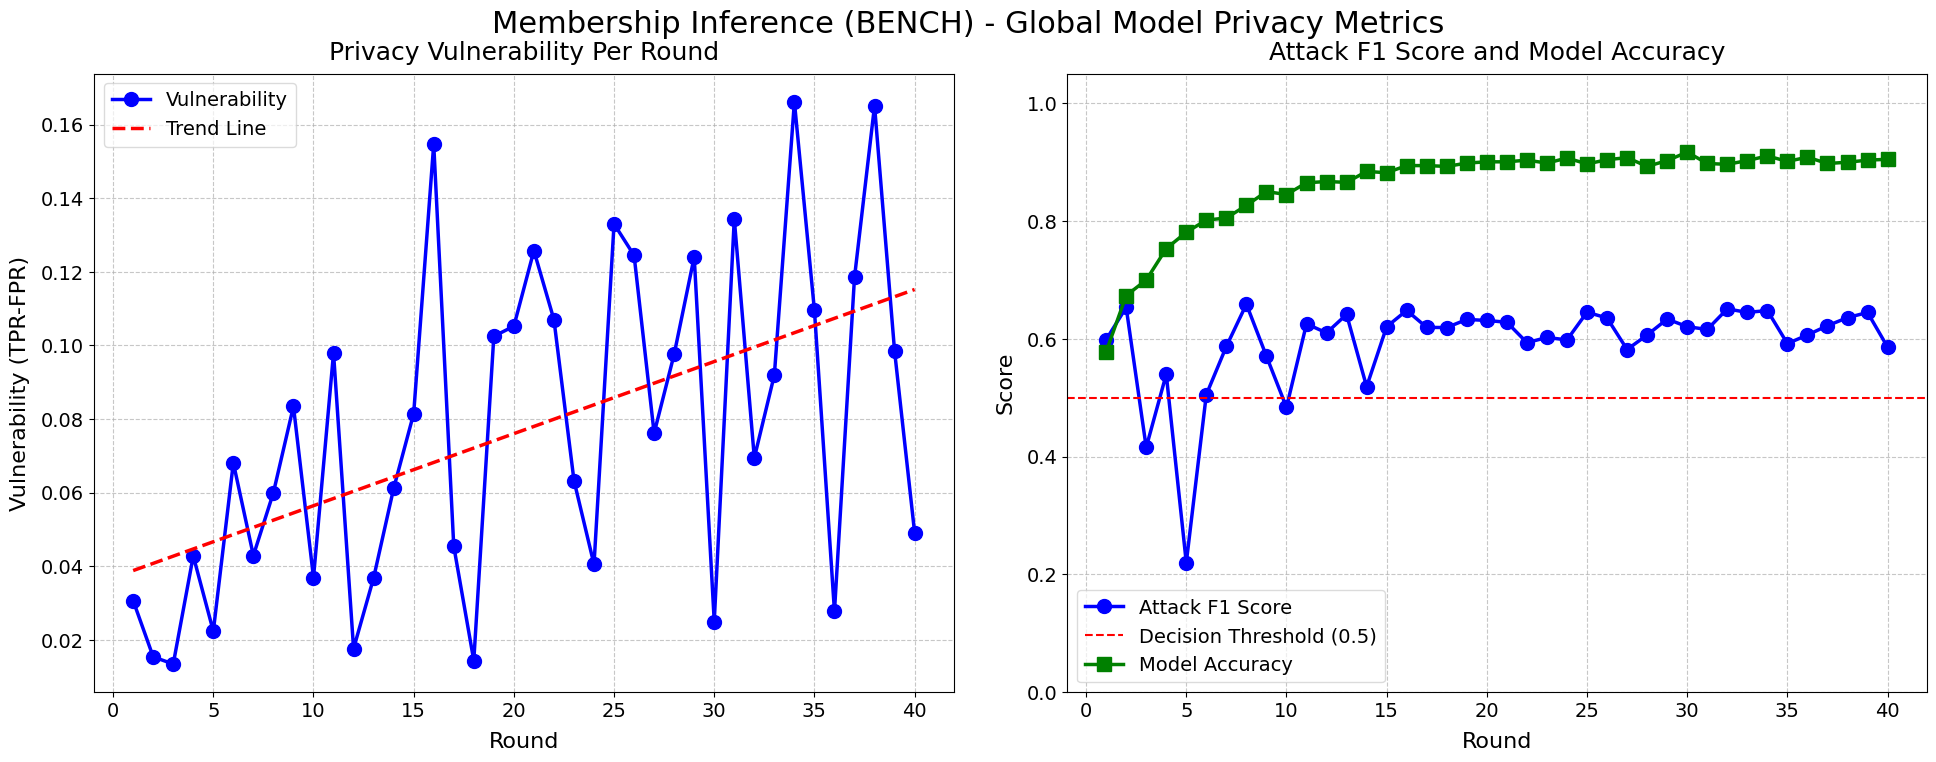

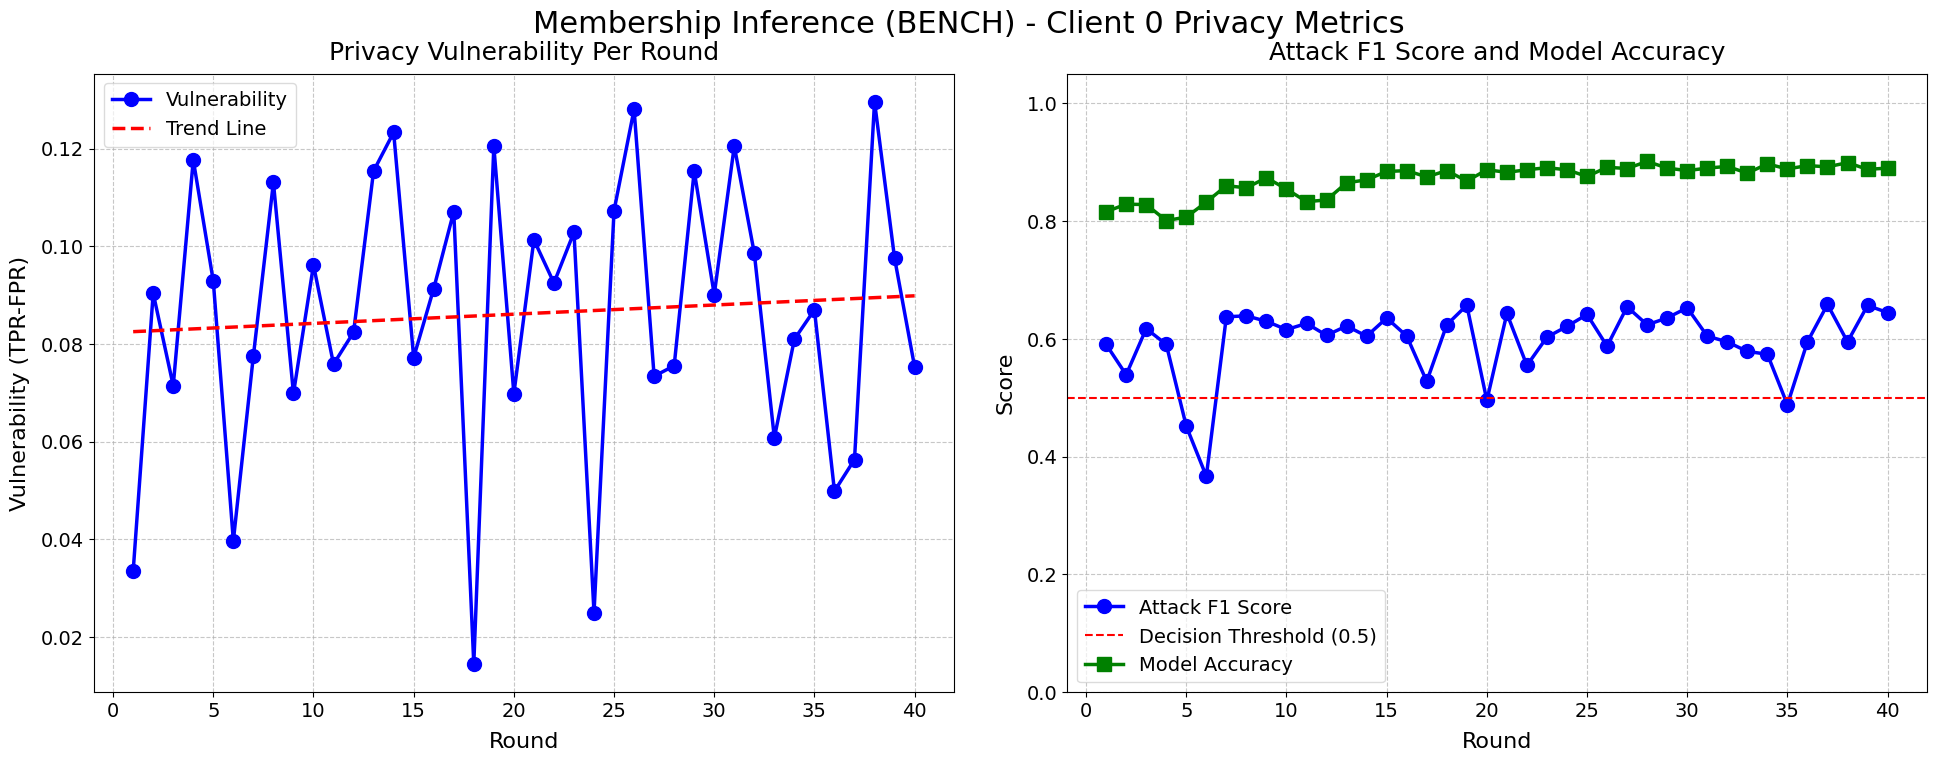

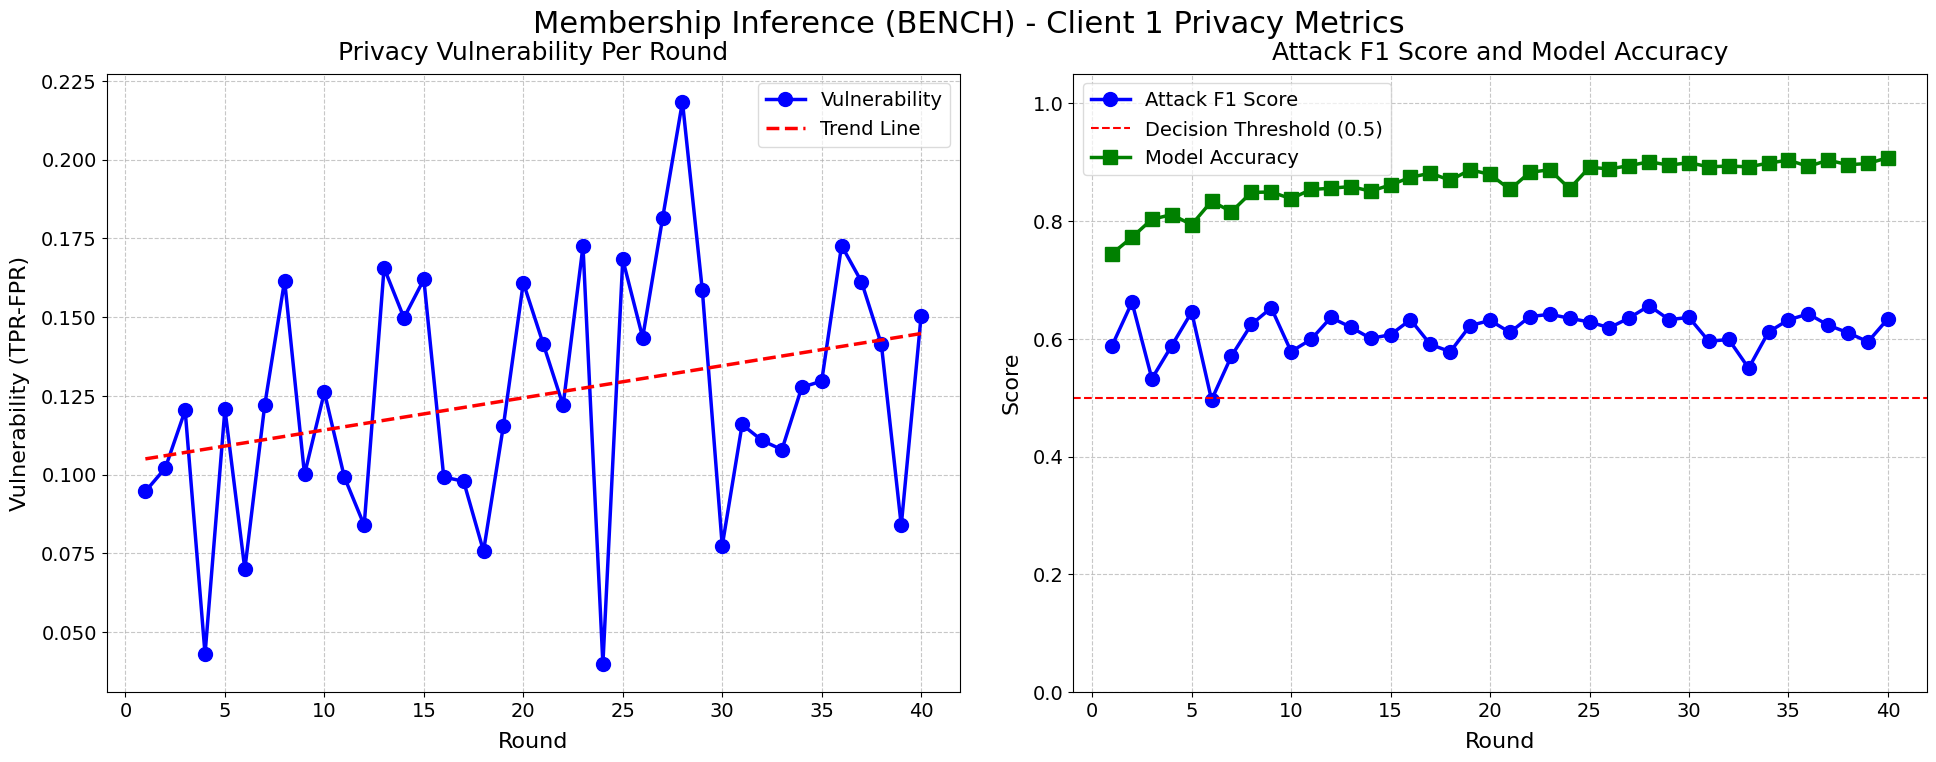

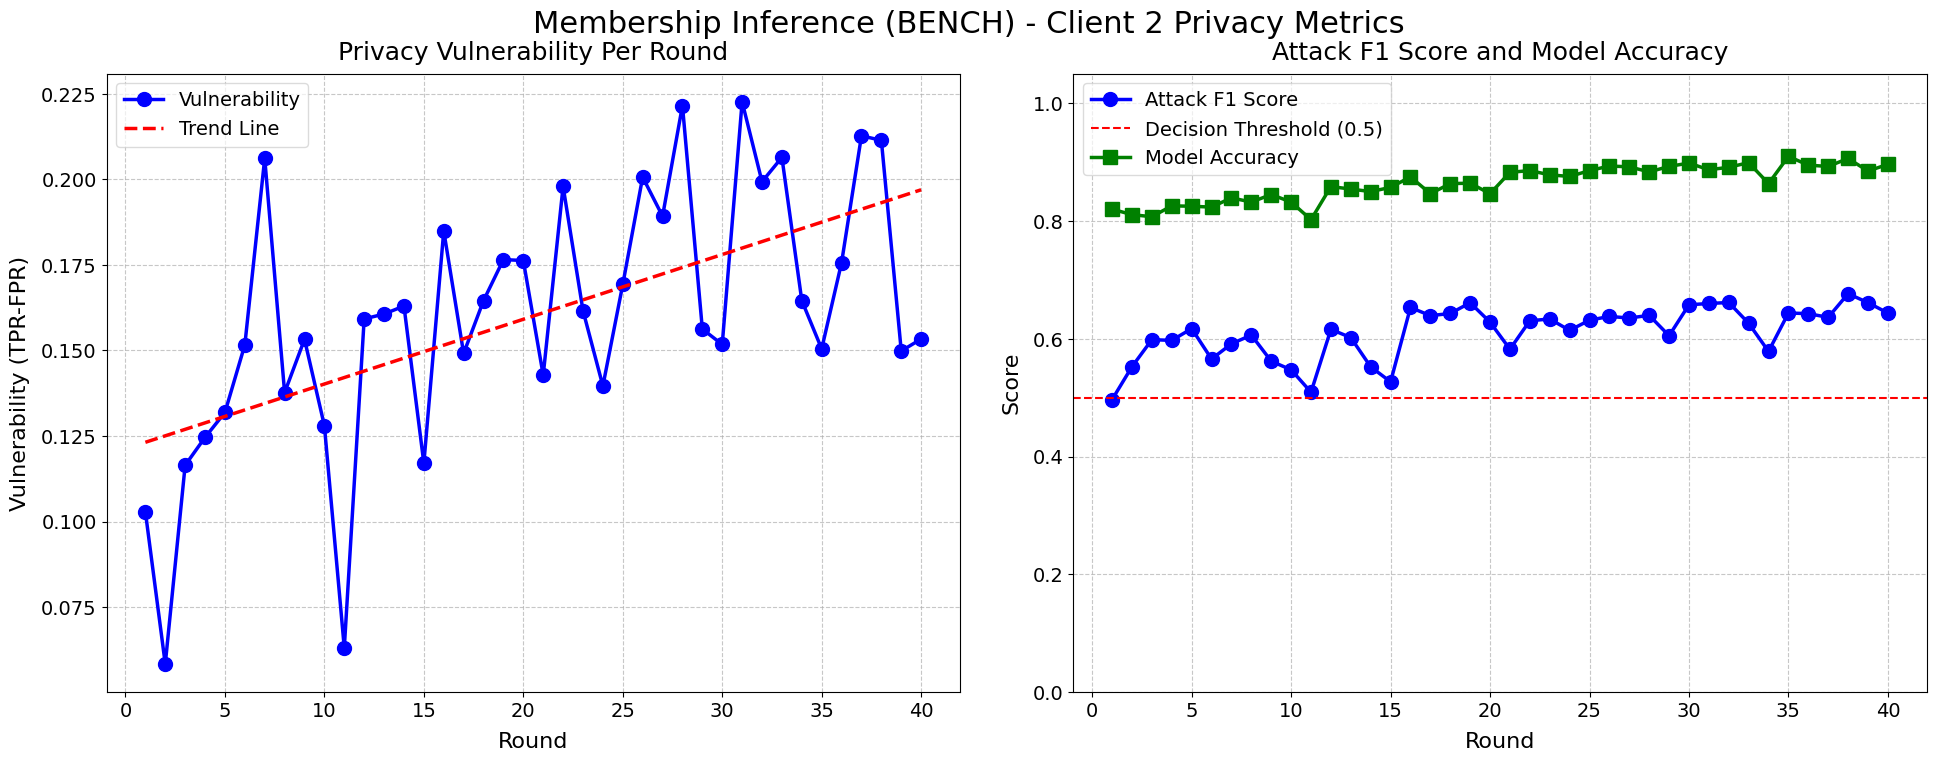

In [ ]:
PRIVACY_EVALUATOR_PATH = '/content/drive/MyDrive/Spring 25/github_brainfl/results/membership_inf/privacy_evaluator_bench.pickle'
GLOBAL_ACC_PATH = '/content/drive/MyDrive/Spring 25/github_brainfl/results/membership_inf/global_accuracies_bench.pickle'
CLIENT_ACC_PATH = '/content/drive/MyDrive/Spring 25/github_brainfl/results/membership_inf/client_accuracies_bench.pickle'

def main():
    """Main function to load data and generate plots."""
    # Load the accuracy data
    global_accuracies = load_pickle_safely(GLOBAL_ACC_PATH)
    client_accuracies = load_pickle_safely(CLIENT_ACC_PATH)

    # Try to load the privacy evaluator
    privacy_evaluator = load_pickle_safely(PRIVACY_EVALUATOR_PATH)

    if privacy_evaluator is None:
        logger.error("Failed to load privacy evaluator - cannot generate privacy metrics plots")
        return

    # Define a title prefix
    title_prefix = "Membership Inference (BENCH) -"

    # Plot for global model (combined subplots)
    plot_vulnerability_and_f1_with_accuracy(
        privacy_evaluator,
        global_accuracies,
        client_accuracies,
        model_type="global",
        title_prefix=title_prefix
    )

    # Plot for each client (combined subplots)
    num_clients = 3  # Adjust based on your data
    for client_id in range(num_clients):
        plot_vulnerability_and_f1_with_accuracy(
            privacy_evaluator,
            global_accuracies,
            client_accuracies,
            model_type="client",
            client_id=client_id,
            title_prefix=title_prefix
        )

if __name__ == "__main__":
    main()

### GS 20% Model/Data

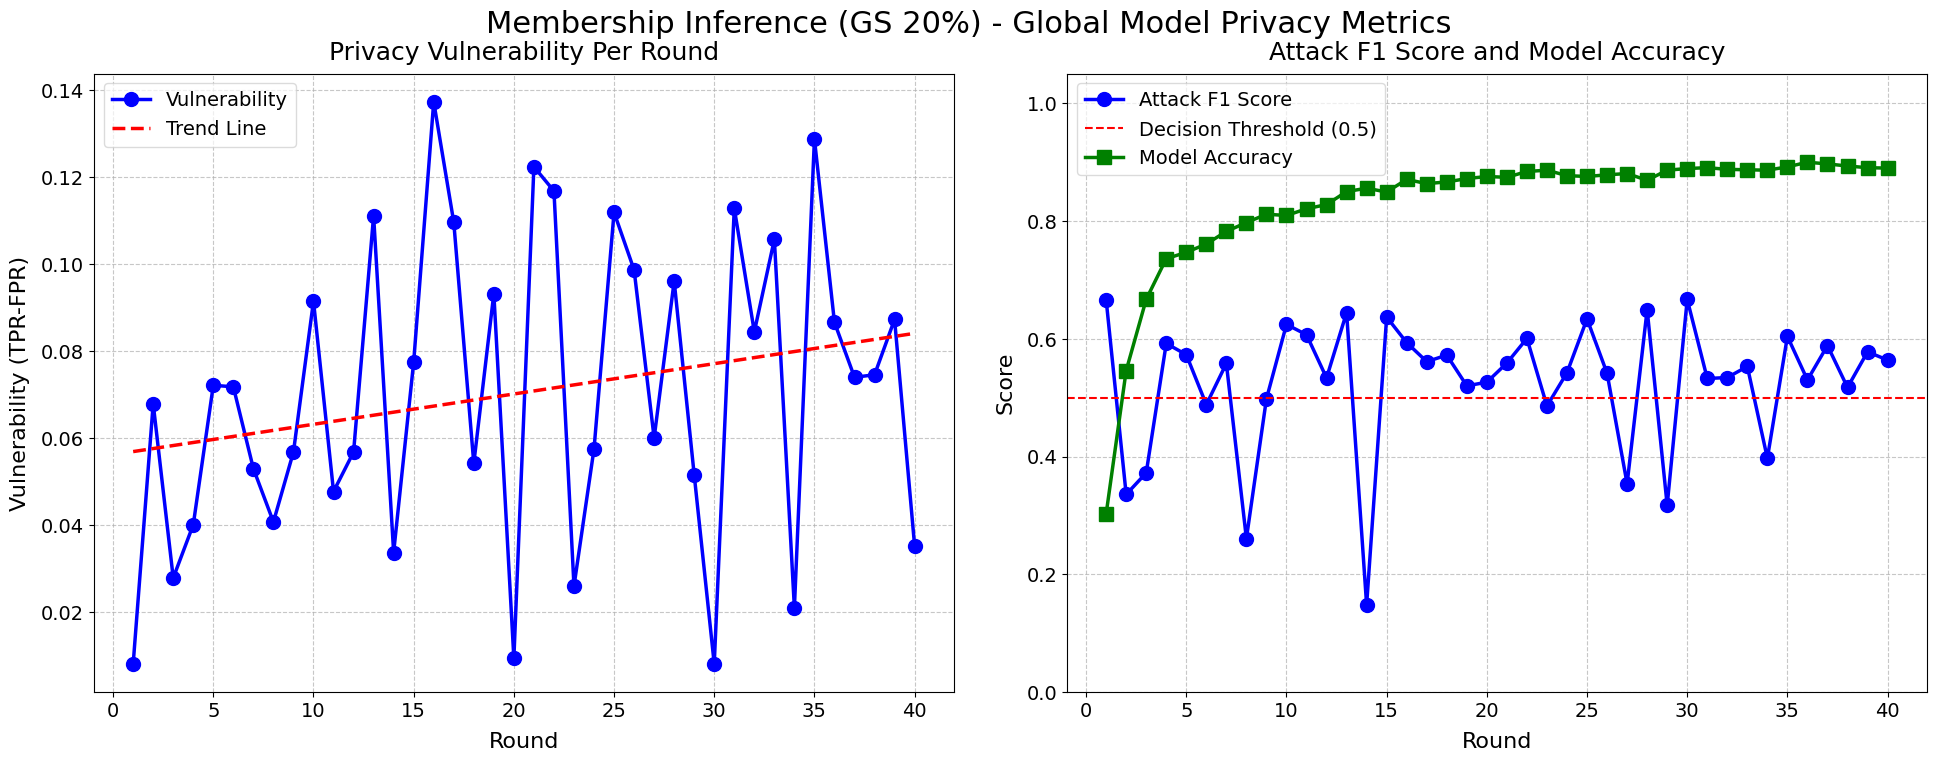

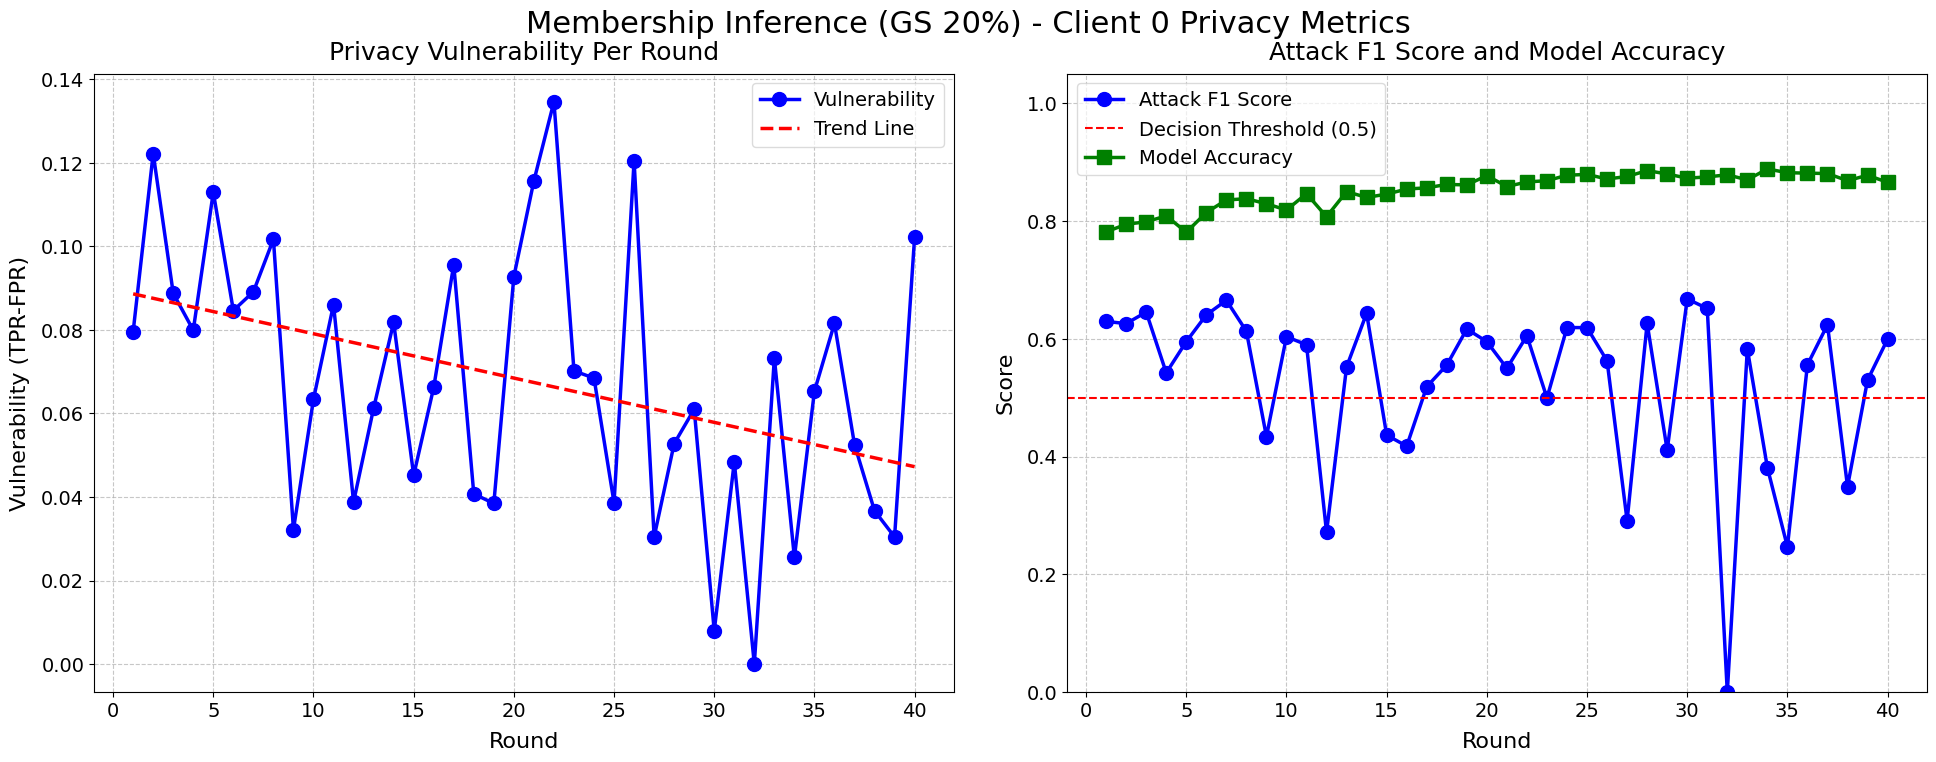

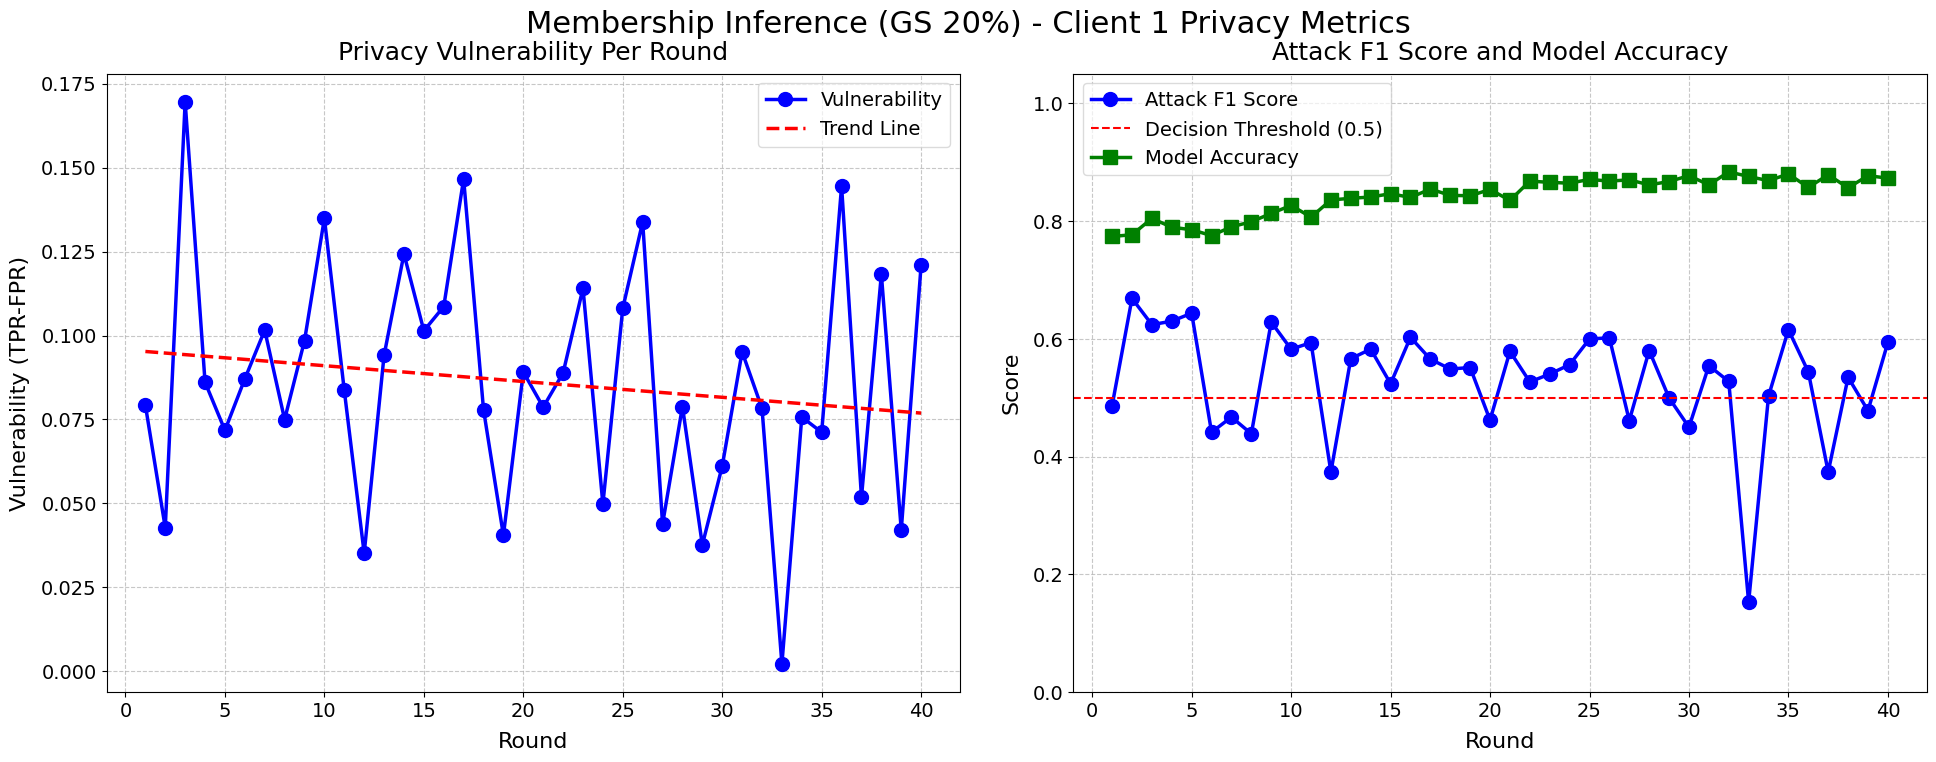

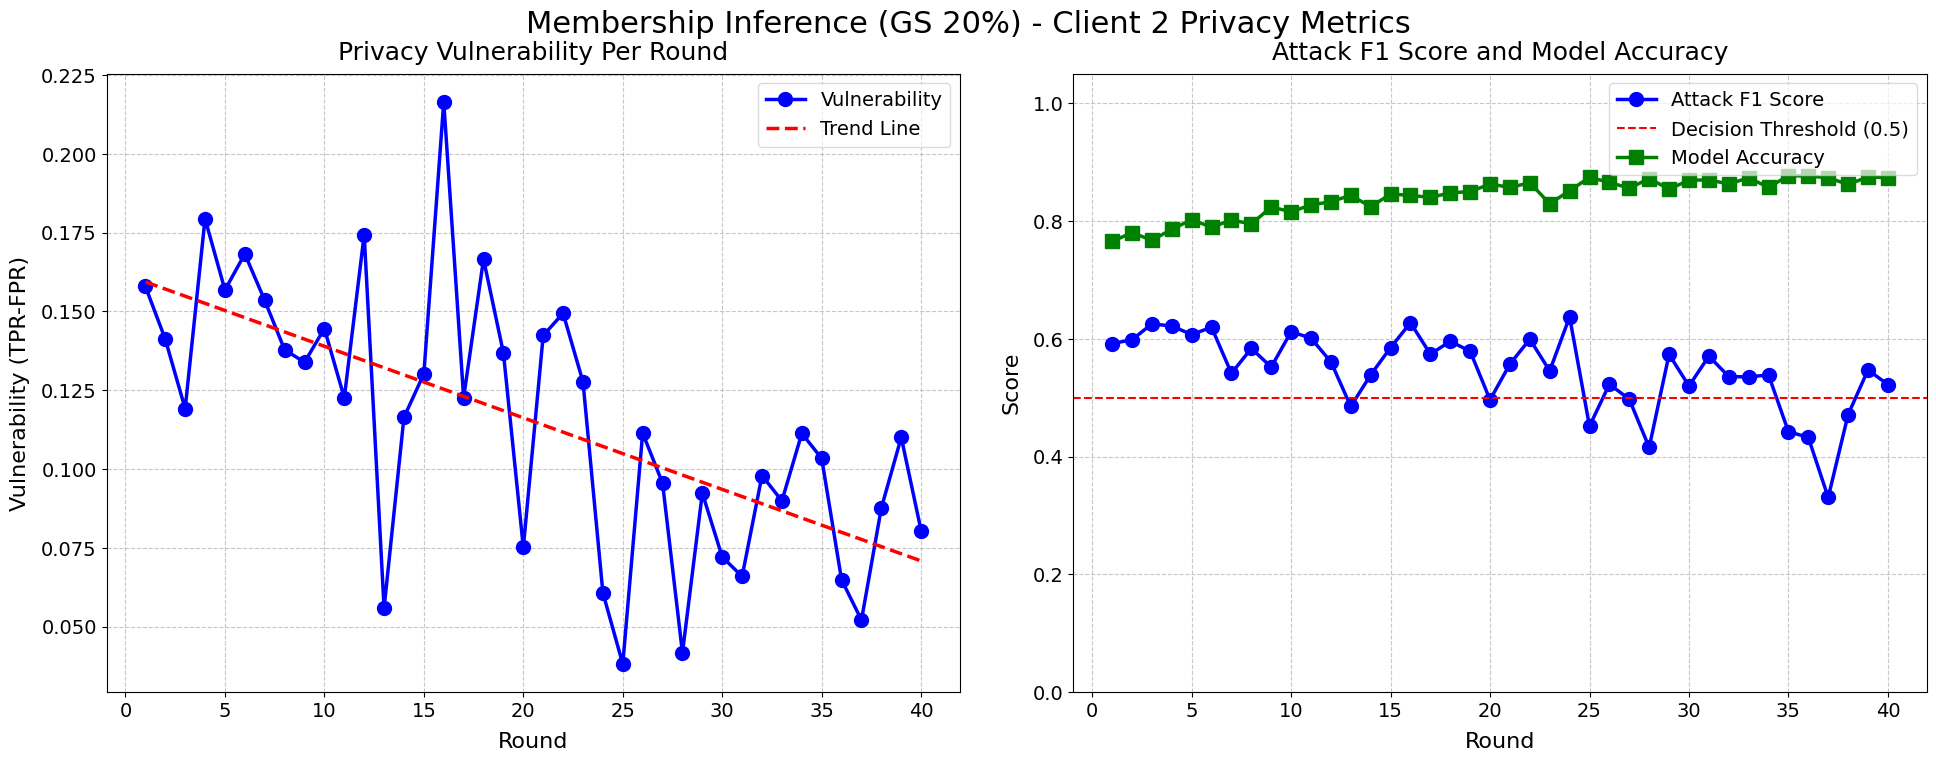

In [ ]:
PRIVACY_EVALUATOR_PATH = '/content/drive/MyDrive/Spring 25/github_brainfl/results/membership_inf/privacy_evaluator_gs20p.pickle'
GLOBAL_ACC_PATH = '/content/drive/MyDrive/Spring 25/github_brainfl/results/membership_inf/global_accuracies_gs20p.pickle'
CLIENT_ACC_PATH = '/content/drive/MyDrive/Spring 25/github_brainfl/results/membership_inf/client_accuracies_gs20p.pickle'

def main():
    """Main function to load data and generate plots."""
    # Load the accuracy data
    global_accuracies = load_pickle_safely(GLOBAL_ACC_PATH)
    client_accuracies = load_pickle_safely(CLIENT_ACC_PATH)

    # Try to load the privacy evaluator
    privacy_evaluator = load_pickle_safely(PRIVACY_EVALUATOR_PATH)

    if privacy_evaluator is None:
        logger.error("Failed to load privacy evaluator - cannot generate privacy metrics plots")
        return

    # Define a title prefix
    title_prefix = "Membership Inference (GS 20%) -"

    # Plot for global model (combined subplots)
    plot_vulnerability_and_f1_with_accuracy(
        privacy_evaluator,
        global_accuracies,
        client_accuracies,
        model_type="global",
        title_prefix=title_prefix
    )

    # Plot for each client (combined subplots)
    num_clients = 3  # Adjust based on your data
    for client_id in range(num_clients):
        plot_vulnerability_and_f1_with_accuracy(
            privacy_evaluator,
            global_accuracies,
            client_accuracies,
            model_type="client",
            client_id=client_id,
            title_prefix=title_prefix
        )

if __name__ == "__main__":
    main()